**Mounting Drive**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Installing Required Libraries**

In [5]:
!pip install torch torchvision numpy matplotlib


**Importing Modules**

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


**Getting Dataset directly from Torchvision library nad transforming it because the ResNet takes 3-channel image as input**

In [7]:
# Define the transformation
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert 1-channel to 3-channel
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image
])

# Load the training and test datasets from torchvision
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


**Loading Pre-Trained Resnet 18**

In [8]:
# Load the pretrained ResNet-18 model
model = models.resnet18(pretrained=True)

# Modify the final layer to have 10 output classes
model.fc = nn.Linear(model.fc.in_features, 10)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Print the device type
if device.type == "cuda":
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 46.8MB/s]


Using GPU: Tesla T4


**Define Loss Function and Optimizer**

In [9]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


**Train the Model**

In [10]:
def train_model(model, train_loader, criterion, optimizer, device, num_epochs):
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        total_batches = len(train_loader)  # Total number of batches in an epoch
        print(f"Epoch [{epoch+1}/{num_epochs}]")

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate loss
            running_loss += loss.item()

            # Print progress for every 100 batches
            if (batch_idx + 1) % 100 == 0:
                print(f"Batch [{batch_idx+1}/{total_batches}], Loss: {loss.item():.4f}")

        # Calculate and print the average loss for the epoch
        epoch_loss = running_loss / total_batches
        print(f"Epoch [{epoch+1}/{num_epochs}] completed. Average Loss: {epoch_loss:.4f}")
        print("-" * 50)

train_model(model, train_loader, criterion, optimizer, device, num_epochs=10)



Epoch [1/10]
Batch [100/938], Loss: 0.1040
Batch [200/938], Loss: 0.0419
Batch [300/938], Loss: 0.0601
Batch [400/938], Loss: 0.0347
Batch [500/938], Loss: 0.0112
Batch [600/938], Loss: 0.1302
Batch [700/938], Loss: 0.0901
Batch [800/938], Loss: 0.0102
Batch [900/938], Loss: 0.0058
Epoch [1/10] completed. Average Loss: 0.0656
--------------------------------------------------
Epoch [2/10]
Batch [100/938], Loss: 0.0059
Batch [200/938], Loss: 0.1240
Batch [300/938], Loss: 0.0138
Batch [400/938], Loss: 0.0043
Batch [500/938], Loss: 0.0632
Batch [600/938], Loss: 0.0081
Batch [700/938], Loss: 0.0196
Batch [800/938], Loss: 0.0239
Batch [900/938], Loss: 0.0058
Epoch [2/10] completed. Average Loss: 0.0348
--------------------------------------------------
Epoch [3/10]
Batch [100/938], Loss: 0.0028
Batch [200/938], Loss: 0.0840
Batch [300/938], Loss: 0.0434
Batch [400/938], Loss: 0.0541
Batch [500/938], Loss: 0.0030
Batch [600/938], Loss: 0.1789
Batch [700/938], Loss: 0.0022
Batch [800/938], Lo

**Testing the Model**

In [11]:
def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

test_model(model, test_loader, device)


Test Accuracy: 99.45%


**Saving the Trained Model**

In [12]:
model_save_path = '/content/drive/MyDrive/mnist_resnet18.pth'
torch.save(model.state_dict(), model_save_path)


**Inference**

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-13-bddb05b4f45d>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recomme

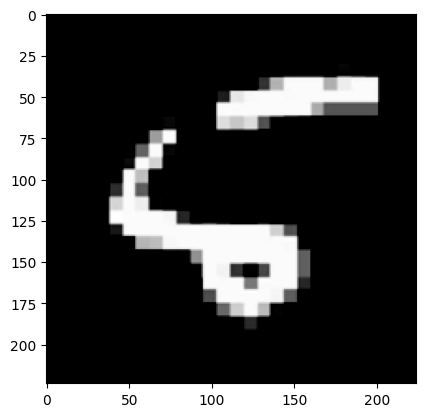

Predicted digit: 5


In [13]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved model
model_save_path = '/content/drive/MyDrive/mnist_resnet18.pth'
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 10)
model.load_state_dict(torch.load(model_save_path))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# Define the transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load an external image
image_path = '/content/drive/MyDrive/5.jpg'
img = Image.open(image_path)

# Apply transformations
img = transform(img)

# Add batch dimension
img = img.unsqueeze(0)
img = img.to(device)

# Show the image (optional)
plt.imshow(img.cpu().squeeze().permute(1, 2, 0).numpy())
plt.show()

# Perform inference
with torch.no_grad():
    output = model(img)

# Get the predicted digit
_, predicted = torch.max(output, 1)
predicted_digit = predicted.item()
print(f"Predicted digit: {predicted_digit}")
